# **Linear Regression with Spark**
#### The assignment concerns a standard supervised learning pipeline, using part of [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) (You can find in [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD)). Our objective is to train a linear regression (LR) model that can anticipate the release year of a song, based on a given set of audio features.

#### The assignment will comprise the following sections:
+  ####*Part 1:* Reading & parsing the original dataset (1 point)
 + #### *Vis. 1:* Features
 + #### *Vis. 2:* Shifting labels
+  ####*Part 2:* Development and assessment of a baseline model (1 point)
 + #### *Vis. 3:* Comparison of predicted vs. actual results
+  ####*Part 3:* Training with gradient descent and evaluatation of a LR model (2 points)
 + #### *Vis. 4:* Examination of training errors
+  ####*Part 4:* Training with MLlib and optimization of hyperparameters using grid search (2 points)
 + #### *Vis. 5:* Predictions of best model
 + #### *Vis. 6:* Heat map representation of hyperparameter
+  ####*Part 5:* Adding interactions between the features (2 points)
 
#### Please note that the relevant Spark methods can be found in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html?highlight=pyspark%20rdd#pyspark.RDD), while the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)Reference provides details of relevant NumPy methods, for reference.

In [1]:
lable = 'comp4651_assignment_3'

### Part 1: Reading & parsing the original dataset (1 point)

#### (1-I) Data Loading and Verification

#### The present location of the authentic information is a textual document. Our first move is to transform this unprocessed information into an RDD format, where each element of the RDD signifies a comma-separated string. The first segment of each unit is denoted by a label, representing a year, and followed by numeric audio features. Utilize the [count method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.count.html?highlight=pyspark%20rdd%20count#pyspark.RDD.count) to verify the number of data points available. Then, use the [take method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.take.html?highlight=pyspark%20rdd%20take#pyspark.RDD.take) to generate and print a list of the first 5 data points in their original string format.

In [2]:
# load testing library
import os.path
fileName = './millionsong.txt'

from pyspark.sql import SparkSession

# create the entry point to Spark
spark = SparkSession.builder \
    .appName("Assignment 3") \
    .getOrCreate()
numPartitions = 2
rawData = spark.sparkContext.textFile(fileName, numPartitions)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/02 17:39:39 WARN Utils: Your hostname, MariusSkole, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/02 17:39:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 17:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# TODO: Replace <FILL IN> with appropriate code
numPoints = rawData.count()
print(numPoints)
samplePoints = rawData.take(5)
print(samplePoints)

6719
['1909.0,0.855682460997,0.598710507938,0.558817963223,0.473756807476,0.269273760192,0.317639663190,0.435869155476,0.364600840647,0.654124295174,0.518441898761,0.584556708250,0.414796689901', '1984.0,0.869807643725,0.642047638428,0.575532221407,0.480015729333,0.278542592772,0.268138416817,0.425631588767,0.371936965167,0.654020360011,0.508430890371,0.654254740382,0.435920442390', '1964.0,0.846711026492,0.622566698354,0.552247260079,0.480574346636,0.252726439476,0.340181705967,0.442953207232,0.433446202231,0.589617477466,0.463379216016,0.656650114283,0.468217836233', '1941.0,0.895738831491,0.637870015943,0.582384095358,0.494381476585,0.257045620004,0.262393528984,0.360039303637,0.403477811741,0.638190798824,0.523476752138,0.586966291449,0.438048566462', '1920.0,0.872205568827,0.595994416438,0.563502650340,0.464833460897,0.292135154170,0.275531584901,0.435234146491,0.395067278960,0.589458841834,0.366209632489,0.671613579959,0.435281465679']


#### (1-II) Store labeled traing instances
#### To store the labeled training instances in MLlib, we use [LabeledPoint](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LabeledPoint.html?highlight=pyspark%20mllib%20regression%20labeledpoint#pyspark.mllib.regression.LabeledPoint) object. We can generate a parsePoint function that takes a raw data point as input, parsing by applying Python's [unicode.split](https://docs.python.org/2/library/string.html#string.split) method to it, and then returns a `LabeledPoint` object. This parsePoint function can be used to parse samplePoints (mentioned in the previous question). Then print out the features and label of the 1st training point using the `LabeledPoint.features` and `LabeledPoint.label` attributes. Finally, we can compute the number of features in this dataset.

#### It is noteworthy that `split()` can be called directly on a `unicode` or `str` object. E.g., `u'split,me'.split(',')` returns `[u'split', u'me']`.

In [4]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [5]:
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    elements = line.split(",")
    features = []
    label = float(elements[0])
    for i,e in enumerate(elements):
        if (i == 0):
            continue
        features.append(float(e))
    return LabeledPoint(label,features)

parsedSamplePoints = rawData.map(parsePoint)
firstPointFeatures = parsedSamplePoints.first().features
firstPointLabel = parsedSamplePoints.first().label
print(firstPointFeatures, firstPointLabel)

d = len(firstPointFeatures)
print(d)

[0.855682460997,0.598710507938,0.558817963223,0.473756807476,0.269273760192,0.31763966319,0.435869155476,0.364600840647,0.654124295174,0.518441898761,0.58455670825,0.414796689901] 1909.0
12


#### Vis. 1: Features
#### Initially, we need to import and configure the visualization library. Next, we intend to examine the crude feature of 50 data points by creating a heatmap that illustrates each feature in a grayscale and displays the variability of each feature among the 50 sample data points. All the features range from 0 to 1, where features closer to 1 are represented with darker shades of grey.

<class 'list'>


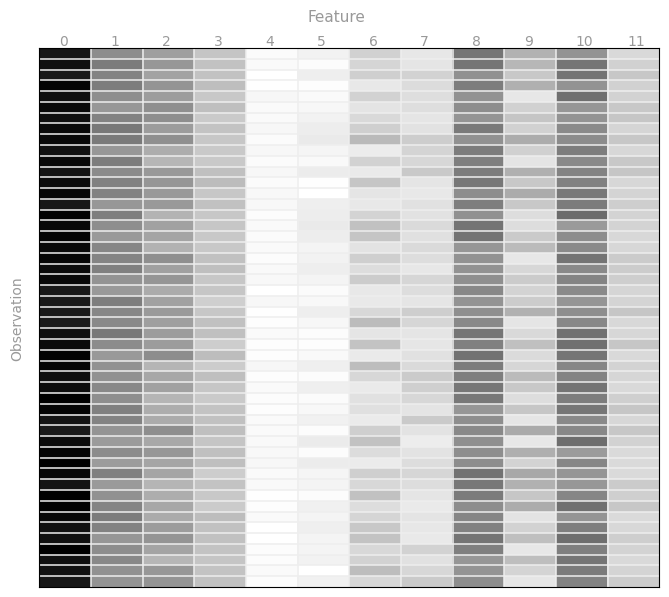

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sampleMorePoints = rawData.take(50)
# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell.  Note that you should run this cell with the line commented
# out when answering the lab quiz questions.
# sampleMorePoints = rawData.takeSample(False, 50)


parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = list(map(lambda lp: lp.features.toArray(), parsedSampleMorePoints))

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
print(type(dataValues))
image = plt.imshow(dataValues, interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
pass

#### (1-III) Explore the range 
#### Our task is to examine the labels and determine the period during which the songs were released. To accomplish this, we need to parse each element of the `rawData` RDD and then find the minimum and maximum labels.

In [7]:
# TODO: Replace <FILL IN> with appropriate code
parsedDataInit = rawData.map(parsePoint)
onlyLabels = parsedDataInit.map(lambda x: x.label)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print(maxYear, minYear)

2008.0 1900.0


#### (1-IV) Shifting labels
#### As we just saw, the labels represent years in the 1900s and 2000s. In machine learning tasks, it's common to shift labels so that they begin from zero. Starting with `parsedDataInit`, we can create a new RDD of `LabeledPoint` objects, with the labels shifted such that the smallest label is zero.

In [8]:
# TODO: Replace <FILL IN> with appropriate code
parsedData = parsedDataInit.map(lambda x: LabeledPoint(x.label-minYear,x.features))

# Should be a LabeledPoint
print(type(parsedData.take(1)[0]))
# View the first point
print('\n{0}'.format(parsedData.take(1)))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(9.0, [0.855682460997,0.598710507938,0.558817963223,0.473756807476,0.269273760192,0.31763966319,0.435869155476,0.364600840647,0.654124295174,0.518441898761,0.58455670825,0.414796689901])]


#### Vis. 2: Shifting labels
#### We will compare the distribution of labels before and after shifting them by plotting two scatter plots. The tuples in both plots store i) a label value, and ii) the number of training points with this label. While the first scatter plot displays the initial labels, the second one visualizes the shifted labels. It's worth noting that both plots look identical, except for the labels on the x-axis.

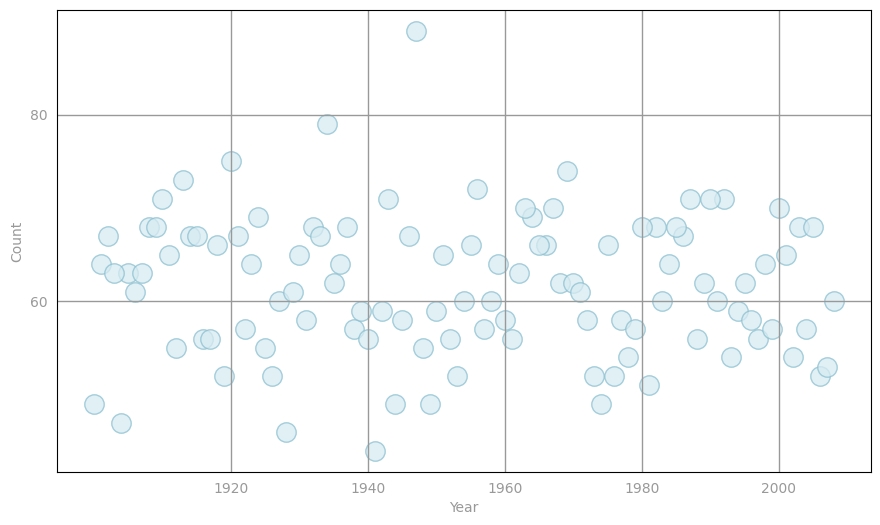

In [9]:
# get data for plot
oldData = (parsedDataInit
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*oldData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
pass

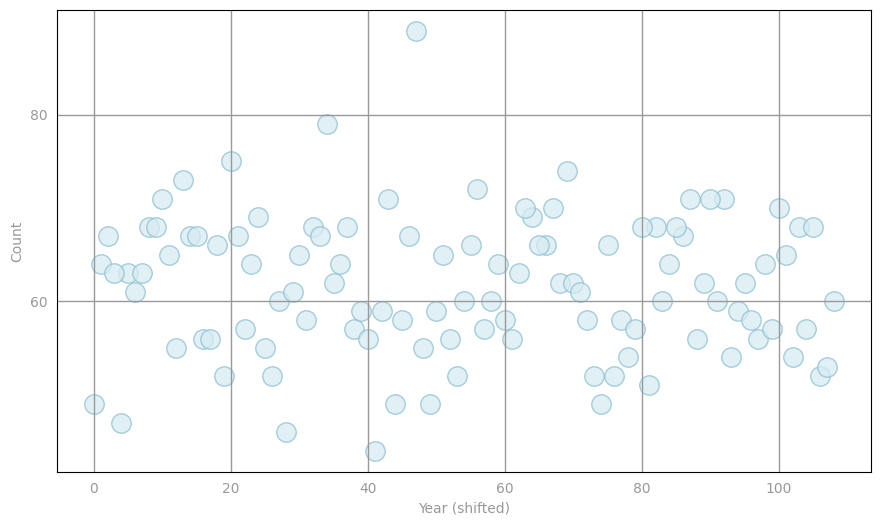

In [10]:
# get data for plot
newData = (parsedData
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*newData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
pass

#### (1-V) Training set, validation set, and test set
#### Our last step in parsing the dataset involves splitting it into training, validation, and test sets. We can use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.randomSplit.html?highlight=pyspark%20rdd%20randomsplit#pyspark.RDD.randomSplit) with predefined weights and a seed to create RDDs for each set. It's essential to cache each of these RDDs as we'll need to access them multiple times later. Finally, we should compute the size of each set and verify that their sum is equal to the total size of the dataset from Part (1-I).

In [11]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights,seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print(nTrain, nVal, nTest, nTrain + nVal + nTest)
print(parsedData.count())

5356 678 685 6719
6719


### Part 2:  Development and assessment of a baseline model (2 point)

#### (2-I) Average label
#### A straightforward baseline model is one where we make the same prediction regardless of the input data. To achieve this, we can use the average label in the training set as the constant prediction value. We can compute this value by using an appropriate method in the [RDD API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html?highlight=pyspark%20rdd#pyspark.RDD).

In [12]:
# TODO: Replace <FILL IN> with appropriate code
averageTrainYear = (parsedTrainData
                    .map(lambda x: x.label).mean())
print(averageTrainYear)

53.81348020911131


#### (2-II) Root mean squared error
#### It's important to evaluate how effective the simple baseline model is, and one commonly used metric for this is the root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)). To calculate the RMSE, we need a function that takes in an RDD of (label, prediction) tuples as input, and test out this function on an example.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
import math
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (label - prediction)*(label - prediction)

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """

    squaredErrors = labelsAndPreds.map(lambda x: squaredError(x[0],x[1]))

    n = squaredErrors.count()

    sum = squaredErrors.reduce(lambda a,b: a+b)
    
    return math.sqrt((1/n)*sum)

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print(exampleRMSE)

1.2909944487358056


#### (2-III) RMSE of Training, validation and test set
#### Let's now compute the root mean squared error (RMSE) of our baseline model on the training, validation, and test datasets. First, we need to create RDDs that contain tuples of (label, prediction) for each dataset. Then, we can use the `calcRMSE` function to compute the RMSE for each dataset. It is worth noting that the RMSE represents the average prediction error in terms of years for each dataset.

In [17]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPredsTrain = parsedTrainData.map(lambda x: (x.label,averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda x: (x.label,averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda x: (x.label,averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 31.410
Baseline Validation RMSE = 32.030
Baseline Test RMSE = 30.845


#### Vis. 3: Comparison of predicted vs. actual results
#### We will generate scatter plots to visualize predictions on the validation dataset. These plots will display tuples that contain i) the predicted value and ii) the true label. The first scatter plot represents the perfect scenario where the predicted value exactly matches the true label. However, in the second plot, we use the baseline predictor (i.e., `averageTrainYear`) for all predicted values. Additionally, note that the scatter plots use a color scheme ranging from light yellow for instances where the true and predicted values are equal, to bright red for instances where they drastically differ.

/tmp/ipykernel_57813/2680503046.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlOrRd')


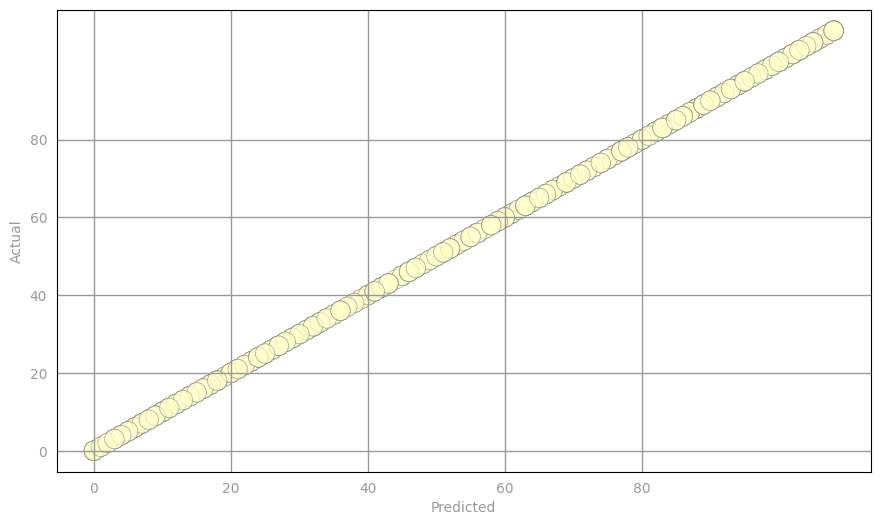

In [18]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1]))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
pass

(Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Actual'))

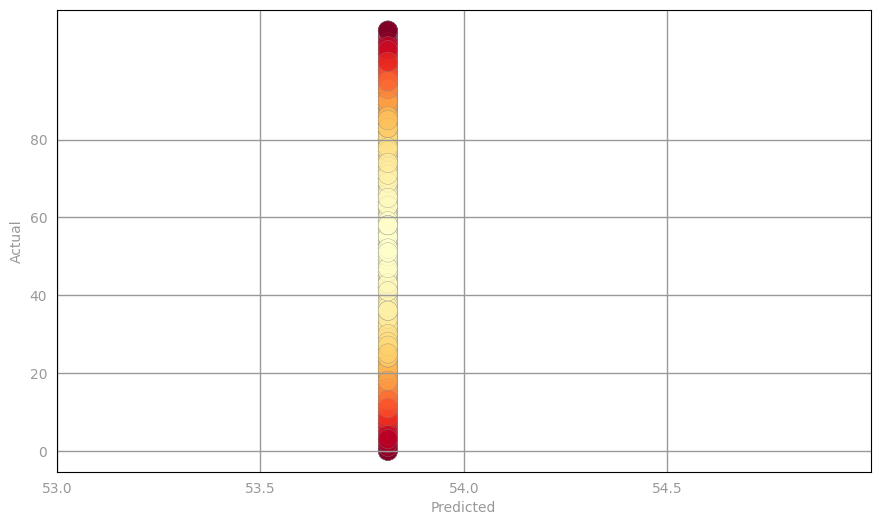

25/12/02 17:57:35 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 162519 ms exceeds timeout 120000 ms
25/12/02 17:57:35 WARN SparkContext: Killing executors is not supported by current scheduler.
25/12/02 17:57:39 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at o

In [19]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, averageTrainYear))
                   .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1]))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

### Part 3: Training with gradient descent and evaluatation of a LR model (2 points)

#### (3-I) Gradient summand
#### Let's attempt to improve our predictions using linear regression with gradient descent (omit the intercept for now). As a reminder, the gradient descent update rule for linear regression is: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ where i is the iteration number of the gradient descent algorithm, and j identifies the observation.
#### First, implement a function that gives the summand for this update, i.e., the summand equals $$ \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \$$ Then you should test this function on two examples.  Using `DenseVector` [dot](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.linalg.DenseVector.html?highlight=pyspark%20mllib%20linalg%20densevector%20dot#pyspark.mllib.linalg.DenseVector.dot) method.

In [ ]:
from pyspark.mllib.linalg import DenseVector

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    w = weights
    x = DenseVector(lp.features)
    y = lp.label
    return (w.dot(x)-y)*x
    

exampleW = DenseVector([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])
# gradientSummand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summandOne = gradientSummand(exampleW, exampleLP)
print(summandOne)

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print(summandTwo)

#### (3-II) Make predictions using weights
#### Subsequently, create a function called `getLabeledPredictions` that takes the weights and a `LabeledPoint` observation and returns a tuple of the form (label, prediction). It is worth noting that the prediction can be obtained by calculating the dot product of the weights with the features of the observation.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return <FILL IN>

weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print(labelsAndPredsExample.collect())

#### (3-III) Gradient descent
#### Next, give a gradient descent function for LR and test on an example.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.<FILL IN>
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = <FILL IN>

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= <FILL IN>
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print(exampleWeights)
print(exampleErrorTrain)

#### (3-IV) Train the model
#### Let's proceed to train a linear regression model on the entire training dataset and then check its accuracy on the validation set. However, it's important to note that we shouldn't evaluate the model on the test set at this stage since doing so could introduce bias in our final results. 
#### We have already completed most of the necessary steps, such as computing the number of features in Part (1—II), creating the training and validation datasets, and determining their sizes in Part (1-V), and also writing a function to calculate RMSE in Part (2-II).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(<FILL IN>)

labelsAndPreds = parsedValData.<FILL IN>
rmseValLR0 = calcRMSE(labelsAndPreds)

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase, rmseValLR0))

#### Vis. 4: Examination of training errors
#### We will examine how the training error changes over iterations by taking the logarithm of the error values. The first scatter plot displays the logarithm of the training error for all 50 iterations. The second plot emphasizes the final 44 iterations and displays the training error directly.

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

### Part 4: Training with MLlib and optimization of hyperparameters using grid search (2 points)

#### (4-I) SGD
#### We have already achieved better performance than the baseline model, however, we will attempt to further improve by introducing an intercept, regularization, and increasing the number of iterations. MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionWithSGD.html?highlight=pyspark%20mllib%20regression%20linearregressionwithsgd#pyspark.mllib.regression.LinearRegressionWithSGD) implements a similar algorithm to what we implemented in Part (3-II), but with more features such as stochastic gradient approximation, the option to include an intercept in the model, and also allowing L1 or L2 regularization. We will start by training a model with LinearRegressionWithSGD that includes an intercept and L2 regularization. This will result in a [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html?highlight=pyspark%20mllib%20regression%20linearregressionmodel#pyspark.mllib.regression.LinearRegressionModel).  Next, . Then, we can use the model's [weights](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html?highlight=pyspark%20mllib%20regression%20linearregressionmodel%20weights#pyspark.mllib.regression.LinearRegressionModel.weights)  and [intercept](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html?highlight=pyspark%20mllib%20regression%20linearregressionmodel%20intercept#pyspark.mllib.regression.LinearRegressionModel.intercept)  attributes to print out the model's parameters.

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
firstModel = LinearRegressionWithSGD.<FILL IN>

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = <FILL IN>
interceptLR1 = <FILL IN>
print(weightsLR1, interceptLR1)

#### (4-II) Prediction
#### Now use the [LinearRegressionModel.predict()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html?highlight=pyspark%20mllib%20regression%20linearregressionmodel%20predict#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point by feeding in the `features` from a `LabeledPoint`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
samplePoint = parsedTrainData.take(1)[0]
samplePrediction = <FILL IN>
print(samplePrediction)

#### (4-III) Evaluate RMSE
#### Subsequently, assess the performance of this model on the validation dataset. Generate an RDD called `labelsAndPreds` by applying the `predict()`  method to the validation dataset. Then, use the `calcRMSE()` function from Part (2-II) to calculate the root-mean-squared error (RMSE) of the model's predictions.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPreds = <FILL IN>
rmseValLR1 = <FILL IN>

print(('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' + '\n\tLR1 = {2:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1))

#### (4-IV) Grid search
#### We're already outperforming the baseline on the validation set by almost 2 years on average. Let's explore whether we can improve our model's performance further by conducting a grid search to determine an optimal regularization parameter. Try with `regParam` values `1e-10`, `1e-5`, and `1`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in <FILL IN>:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print(rmseValGrid)

    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model
rmseValLRGrid = bestRMSE

print(('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' + '\tLRGrid = {3:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid))

#### Vis. 5: Predictions of best model
#### We will now generate a plot similar to 'Vis. 3: Comparison of predicted vs. actual results' from Part 2. This plot will be based on the predictions made by the best model obtained from Part (4-IV) on the validation dataset. The plot will be a scatter plot that uses different colors to represent tuples comprising i) the predicted value from the best model and ii) the corresponding true label.

In [ ]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: bestModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, bestModel.predict(lp.features)))
                   .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1]))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

#### (4-V) Vary 'alpha' and number of iterations
#### Let's experiment with varying the value of `alpha` in the grid search. We will test two different values of `alpha`: `1e-5` and `10`. Additionally, we will train models for two different numbers of iterations: 5 and 500. After training the models, we will evaluate them on the validation set. It is important to note that if `alpha` is set too small, the gradient descent algorithm will require a large number of steps to converge to the solution, and if `alpha` is too large, it can cause numerical problems, as we will see below for `alpha = 10`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
reg = bestRegParam
modelRMSEs = []

for alpha in <FILL IN>:
    for numIters in <FILL IN>:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print('alpha = {0:.0e}, numIters = {1}, RMSE = {2:.3f}'.format(alpha, numIters, rmseVal))
        modelRMSEs.append(rmseVal)

#### Vis. 6: Heat map representation of hyperparameter

#### Next, we perform a visualization of hyperparameter search, using a larger range of hyperparameters (with precomputed outcomes). This visualization takes the form of a heatmap, with brighter colors indicating lower RMSE values. The first plot has a large area with brighter colors, making it difficult to distinguish between the different hyperparameter values. To address this issue, we will create a second plot that focuses on the hyperparameters found within that region, allowing us to differentiate between them more easily.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)

In [ ]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
pass

### Part 5: Adding interactions between the features (2 points)

#### (5-I) 2-way interactions
#### Up until now, we have utilized the existing features as they were provided to us. However, we now aim to improve our model's performance by introducing additional features that capture the two-way interactions between our existing features. Write a function `twoWayInteractions` which accepts a `LabeledPoint` as input and generate a new `LabeledPoint` containing the original features as well as the two-way interactions between them. It is worth noting that if we have a dataset with three features, we would have nine possible two-way interactions ($\scriptsize 3^2$).

#### We can leverage the [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) function to generate tuples for each possible two-way interaction. Furthermore, we can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
import itertools

def twoWayInteractions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    <FILL IN>

print(twoWayInteractions(LabeledPoint(0.0, [2, 3])))

# Transform the existing train, validation, and test sets to include two-way interactions.
trainDataInteract = <FILL IN>
valDataInteract = <FILL IN>
testDataInteract = <FILL IN>

#### (5-II) Build interaction model
#### We will now create a model using the newly generated features. The process for creating this model is similar to what we have done before, but with some minor changes in variable names. As always, we will train the model on the training data and evaluate its performance on the validation data.
####  It is important to note that we need to conduct another hyperparameter search, since the best hyperparameters for our previous model may not necessarily be optimal for the new model with the added features. However, we have already set reasonable values for the hyperparameters for this exercise.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

modelInteract = LinearRegressionWithSGD.train(<FILL IN>, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
labelsAndPredsInteract = <FILL IN>.map(lambda lp: (lp.label, <FILL IN>.predict(lp.features)))
rmseValInteract = calcRMSE(labelsAndPredsInteract)

print(('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' + '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid, rmseValInteract))

#### (5-III) Evaluate interaction model on test set
#### To assess the performance of our model on new data, we will evaluate it on the test set. It is important to note that we did not use the test set to evaluate any of our models during the development phase. Therefore, the test set provides an unbiased estimate of the performance of our model on new data. If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.
#### We will also calculate the RMSE for both the baseline model and our new model. This will allow us to quantify the improvement in performance that our model provides over the baseline model.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPredsTest = <FILL IN>
rmseTestInteract = <FILL IN>

print(('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'.format(rmseTestBase, rmseTestInteract)))